In [ ]:
%%capture
!pip install simpletransformers

### runs

In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs

import os
import json
import math
import random
import pandas as pd
from random import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, fbeta_score, precision_recall_fscore_support

In [ ]:
# Custom classification report from sklearn with F0.5 score

from sklearn.metrics import precision_score, recall_score, fbeta_score, precision_recall_fscore_support
from sklearn.utils import _unique
from sklearn.metrics import _classification
from sklearn.utils import multiclass
import warnings
import numpy as np
from numbers import Integral, Real
from sklearn.utils._param_validation import (
	Hidden,
	Interval,
	Options,
	StrOptions,
	validate_params,
)

@validate_params(
	{
		"y_true": ["array-like", "sparse matrix"],
		"y_pred": ["array-like", "sparse matrix"],
		"labels": ["array-like", None],
		"target_names": ["array-like", None],
		"sample_weight": ["array-like", None],
		"digits": [Interval(Integral, 0, None, closed="left")],
		"output_dict": ["boolean"],
		"zero_division": [
			Options(Real, {0.0, 1.0}),
			"nan",
			StrOptions({"warn"}),
		],
	},
	prefer_skip_nested_validation=True,
)
def classification_report_f0_5(
	y_true,
	y_pred,
	*,
	labels=None,
	target_names=None,
	sample_weight=None,
	digits=2,
	output_dict=False,
	zero_division="warn",
):
	"""Build a text report showing the main classification metrics.

	Read more in the :ref:`User Guide <classification_report>`.

	Parameters
	----------
	y_true : 1d array-like, or label indicator array / sparse matrix
		Ground truth (correct) target values.

	y_pred : 1d array-like, or label indicator array / sparse matrix
		Estimated targets as returned by a classifier.

	labels : array-like of shape (n_labels,), default=None
		Optional list of label indices to include in the report.

	target_names : array-like of shape (n_labels,), default=None
		Optional display names matching the labels (same order).

	sample_weight : array-like of shape (n_samples,), default=None
		Sample weights.

	digits : int, default=2
		Number of digits for formatting output floating point values.
		When ``output_dict`` is ``True``, this will be ignored and the
		returned values will not be rounded.

	output_dict : bool, default=False
		If True, return output as dict.

		.. versionadded:: 0.20

	zero_division : {"warn", 0.0, 1.0, np.nan}, default="warn"
		Sets the value to return when there is a zero division. If set to
		"warn", this acts as 0, but warnings are also raised.

		.. versionadded:: 1.3
		   `np.nan` option was added.

	Returns
	-------
	report : str or dict
		Text summary of the precision, recall, F1 score for each class.
		Dictionary returned if output_dict is True. Dictionary has the
		following structure::

			{'label 1': {'precision':0.5,
						 'recall':1.0,
						 'f1-score':0.67,
						 'support':1},
			 'label 2': { ... },
			  ...
			}

		The reported averages include macro average (averaging the unweighted
		mean per label), weighted average (averaging the support-weighted mean
		per label), and sample average (only for multilabel classification).
		Micro average (averaging the total true positives, false negatives and
		false positives) is only shown for multi-label or multi-class
		with a subset of classes, because it corresponds to accuracy
		otherwise and would be the same for all metrics.
		See also :func:`precision_recall_fscore_support` for more details
		on averages.

		Note that in binary classification, recall of the positive class
		is also known as "sensitivity"; recall of the negative class is
		"specificity".

	See Also
	--------
	precision_recall_fscore_support: Compute precision, recall, F-measure and
		support for each class.
	confusion_matrix: Compute confusion matrix to evaluate the accuracy of a
		classification.
	multilabel_confusion_matrix: Compute a confusion matrix for each class or sample.

	Examples
	--------
	>>> from sklearn.metrics import classification_report
	>>> y_true = [0, 1, 2, 2, 2]
	>>> y_pred = [0, 0, 2, 2, 1]
	>>> target_names = ['class 0', 'class 1', 'class 2']
	>>> print(classification_report(y_true, y_pred, target_names=target_names))
				  precision    recall  f1-score   support
	<BLANKLINE>
		 class 0       0.50      1.00      0.67         1
		 class 1       0.00      0.00      0.00         1
		 class 2       1.00      0.67      0.80         3
	<BLANKLINE>
		accuracy                           0.60         5
	   macro avg       0.50      0.56      0.49         5
	weighted avg       0.70      0.60      0.61         5
	<BLANKLINE>
	>>> y_pred = [1, 1, 0]
	>>> y_true = [1, 1, 1]
	>>> print(classification_report(y_true, y_pred, labels=[1, 2, 3]))
				  precision    recall  f1-score   support
	<BLANKLINE>
			   1       1.00      0.67      0.80         3
			   2       0.00      0.00      0.00         0
			   3       0.00      0.00      0.00         0
	<BLANKLINE>
	   micro avg       1.00      0.67      0.80         3
	   macro avg       0.33      0.22      0.27         3
	weighted avg       1.00      0.67      0.80         3
	<BLANKLINE>
	"""

	y_true, y_pred = _unique.attach_unique(y_true, y_pred)
	y_type, y_true, y_pred = _classification._check_targets(y_true, y_pred)

	if labels is None:
		labels = multiclass.unique_labels(y_true, y_pred)
		labels_given = False
	else:
		labels = np.asarray(labels)
		labels_given = True

	# labelled micro average
	micro_is_accuracy = (y_type == "multiclass" or y_type == "binary") and (
		not labels_given or (set(labels) >= set(multiclass.unique_labels(y_true, y_pred)))
	)

	if target_names is not None and len(labels) != len(target_names):
		if labels_given:
			warnings.warn(
				"labels size, {0}, does not match size of target_names, {1}".format(
					len(labels), len(target_names)
				)
			)
		else:
			raise ValueError(
				"Number of classes, {0}, does not match size of "
				"target_names, {1}. Try specifying the labels "
				"parameter".format(len(labels), len(target_names))
			)
	if target_names is None:
		target_names = ["%s" % l for l in labels]

	headers = ["precision", "recall", "f0.5-score", "support"]
	# compute per-class results without averaging
	p, r, f1, s = precision_recall_fscore_support(
		y_true,
		y_pred,
		labels=labels,
		beta=0.5,
		average=None,
		sample_weight=sample_weight,
		zero_division=zero_division,
	)
	rows = zip(target_names, p, r, f1, s)

	if y_type.startswith("multilabel"):
		average_options = ("micro", "macro", "weighted", "samples")
	else:
		average_options = ("micro", "macro", "weighted")

	if output_dict:
		report_dict = {label[0]: label[1:] for label in rows}
		for label, scores in report_dict.items():
			report_dict[label] = dict(zip(headers, [float(i) for i in scores]))
	else:
		longest_last_line_heading = "weighted avg"
		name_width = max(len(cn) for cn in target_names)
		width = max(name_width, len(longest_last_line_heading), digits)
		head_fmt = "{:>{width}s} " + " {:>9}" * len(headers)
		report = head_fmt.format("", *headers, width=width)
		report += "\n\n"
		row_fmt = "{:>{width}s} " + " {:>9.{digits}f}" * 3 + " {:>9}\n"
		for row in rows:
			report += row_fmt.format(*row, width=width, digits=digits)
		report += "\n"

	# compute all applicable averages
	for average in average_options:
		if average.startswith("micro") and micro_is_accuracy:
			line_heading = "accuracy"
		else:
			line_heading = average + " avg"

		# compute averages with specified averaging method
		avg_p, avg_r, avg_f1, _ = precision_recall_fscore_support(
			y_true,
			y_pred,
			labels=labels,
			beta=0.5,
			average=average,
			sample_weight=sample_weight,
			zero_division=zero_division,
		)
		avg = [avg_p, avg_r, avg_f1, np.sum(s)]

		if output_dict:
			report_dict[line_heading] = dict(zip(headers, [float(i) for i in avg]))
		else:
			if line_heading == "accuracy":
				row_fmt_accuracy = (
					"{:>{width}s} "
					+ " {:>9.{digits}}" * 2
					+ " {:>9.{digits}f}"
					+ " {:>9}\n"
				)
				report += row_fmt_accuracy.format(
					line_heading, "", "", *avg[2:], width=width, digits=digits
				)
			else:
				report += row_fmt.format(line_heading, *avg, width=width, digits=digits)

	if output_dict:
		if "accuracy" in report_dict.keys():
			report_dict["accuracy"] = report_dict["accuracy"]["precision"]
		return report_dict
	else:
		return report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, fbeta_score, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

# I used 'provide_confusion_matrix' , 'calculate_precision_recall_f1score' , 'evaluation_model' functions from previous term
def provide_confusion_matrix(GoldLabel, PredictLabel, label_set):
	"""
	use `sklearn.metric confusion_matrix` to create confusion matrix of model predict.
	and `sklearn.metric ConfusionMatrixDisplay` to display created confusion matrix.

	Parameters
	----------
	GoldLabel : list
		list of all Gold labels
	PredictLabel : list
		list of all Prediction labels
	label_set : list
		list of all classes

	Returns
	-------
		Confusion matrix
	"""
	print(label_set)
	cf_matrix = confusion_matrix(GoldLabel, PredictLabel) # create a confusion matrix with gold and predicts
	print(cf_matrix) # print confusion_matrix as text
	display = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=label_set) # create graphical confusion_matrix
	fig, ax = plt.subplots()# figsize=(15,15)) # create bigger plot because there is many classes in this task
	display.plot(ax =ax) # show confusion_matrix
	plt.xticks(rotation=90) # rotate X label of plot 90 degree
	plt.show() # show confusion matrix
	return cf_matrix # return confusion_matrix (maybe useful later)

def calculate_precision_recall_f05score(GoldLabel, PredictLabel, label_set): # function get gold and predict and set of labels
	"""
	use `sklearn.metric classification_report` to get report of model predict.

	Parameters
	----------
	GoldLabel : list
		list of all Gold labels
	PredictLabel : list
		list of all Prediction labels
	label_set : list
		list of all classes

	Returns
	-------
		Classification report
	"""
	print(label_set)
	report = classification_report_f0_5(GoldLabel, PredictLabel, digits = 3, target_names=label_set) # calculate report
	print(report) # print report
	return report # return report (maybe useful later)


def fine_tune_eval(GoldLabel, PredictLabel, target_names): # get gold and predict
	"""
	Evaluation models by call `calculate_precision_recall_f1score` and `provide_confusion_matrix` functions.

	Parameters
	----------
	data :
		Train or test or dev dataset (after extracting fetures)
	PredictLabel : list
		list of all Prediction labels

	Returns
	-------
		Classification report and Confusion matrix
	"""
	label_set = target_names

	print(label_set)

	print('precision_recall_f1-score')
	report = calculate_precision_recall_f05score(GoldLabel, PredictLabel, label_set) # calculate_precision_recall_f1score

	print('Confusion matrix')
	cf_matrix = provide_confusion_matrix(GoldLabel, PredictLabel, label_set) # provide_confusion_matrix

	return report, cf_matrix # return report and cf_matrix


In [ ]:
def fine_tune_model(model_path, train_data, save_dir, model_name, seed_value):
  """
  Fine-tune a pre-trained model using the Simple Transformers library.
  Args:
    model_path (str): Path to the pre-trained model.
	train_data (pd.DataFrame): Training data in a pandas DataFrame format.
	save_dir (str): Directory to save the fine-tuned model.
	model_name (str): Name of the model being fine-tuned.
	seed_value (int): Seed value for reproducibility.
  Returns:
	model (ClassificationModel): The fine-tuned model.
  """
  # Define model arguments
  model_args = ClassificationArgs(
								  save_eval_checkpoints=False,
								  output_dir=f'{save_dir}/seed_fine_tuned_{model_name}_model',
								  save_model_every_epoch=False,
								  save_steps=-1,
								  manual_seed=seed_value,
								  num_train_epochs=5,
								  overwrite_output_dir=True,
								  labels_list=['G', 'PREP', 'DET','SVA']
								  )

  model = ClassificationModel('roberta', model_path, args=model_args, num_labels=4, use_cuda=True)
  model.train_model(train_data)

  return model

In [ ]:
def predict_model(model_path, test_data):
  """
  Predict labels for test data using a fine-tuned model.
  Args:
	model_path (str): Path to the fine-tuned model.
	test_data (pd.DataFrame): Test data in a pandas DataFrame format.
  Returns:
	predictions (list): List of predicted labels for the test data.
  """
  model = ClassificationModel('roberta', model_path)
  predictions, raw_outputs = model.predict(test_data)

  return predictions


In [ ]:
main_path = "/content/drive/MyDrive/VU Thesis/Code/fine_tune"
data_path = "/content/drive/MyDrive/VU Thesis/Code/fine_tune/data"
save_path = "/content/drive/MyDrive/VU Thesis/Code/fine_tune/models"

In [ ]:
print("loading data...")

print("loading train_data.csv")
train_df =pd.read_csv(os.path.join(data_path, "train_data.csv"))

print("loading dev_data.csv")
dev_df =pd.read_csv(os.path.join(data_path, "dev_data.csv"))

print("loading test_data.csv")
test_df =pd.read_csv(os.path.join(data_path, "test_data.csv"))

print("loading data compelete.")

loading data...
loading train_data.csv
loading dev_data.csv
loading test_data.csv
loading data compelete.


In [ ]:
train_df.head()

,text,labels,UID
0,The libraries that have worked with Christina ...,G,sentential_negation_npi_scope
1,The person joke around.,SVA,irregular_plural_subject_verb_agreement_2
2,I was rather thirsty and hungry after the show...,PREP,Preposition_Unnecessary
3,Most students go to these restaurant.,DET,determiner_noun_agreement_2
4,The report about the Great Lakes are astoundin...,SVA,distractor_agreement_relational_noun


In [ ]:
test_data = list(test_df.text)#.to_list()
gold_labels = list(test_df.labels)#.to_list()
print(len(test_data), len(gold_labels))

6988 6988


In [ ]:
test_data[:20]

['Those customers examine those commentaries.',
 'Even Carlos will often happen to die.',
 'Ordinary lessons attended by students from different levels of ability.',
 'Margaret has said Craig discusses himself.',
 'Julia skated around that popular cafe.',
 'Modern technology is used all the time at home, at school or working.',
 'Many senators scan this black newspaper articles.',
 'I thought it was a good idea to tell to Pat because we could use it to look for exams, and then we could pass all of them.',
 "Robert couldn't embarrass that scared people.",
 "It's himself who Brad talked to.",
 "Lori isn't messing up that tooth.",
 'Guy bored that troubled man.',
 'I can play games, listen to music, and I can do my course work in the computer.',
 'People were sitting down.',
 "Homer wouldn't go to these banks.",
 'Thomas has hidden those small tooth.',
 'Deanna explores these oasis.',
 'Caroline was observing that standing man.',
 'This analysis has appeared to alarm Steve.',
 "Lori hasn'

### models

#### E1

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e1_v20_l4 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


['DET', 'G', 'PREP', 'SVA']
precision_recall_f1-score
['DET', 'G', 'PREP', 'SVA']
              precision    recall f0.5-score   support

         DET      0.985     0.998     0.988      1508
           G      0.909     0.782     0.880      3494
        PREP      0.563     0.873     0.606       879
         SVA      0.863     0.850     0.861      1107

    accuracy                          0.851      6988
   macro avg      0.830     0.876     0.833      6988
weighted avg      0.874     0.851     0.866      6988

Confusion matrix
['DET', 'G', 'PREP', 'SVA']
[[1505    3    0    0]
 [  20 2732  596  146]
 [   0  109  767    3]
 [   3  163    0  941]]


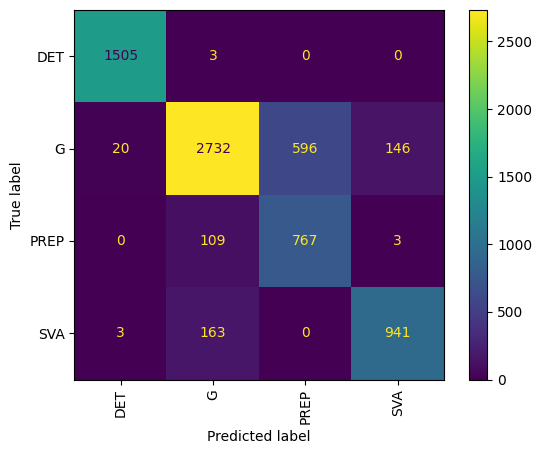

In [ ]:
model_path_e1 = "/content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e1_v20_l4"
model_name_e1 = "v20_l4_e1"
seed_val = 20
model_e1 = fine_tune_model(model_path_e1, train_df, save_path, f"{model_name_e1}_s{seed_val}", seed_val)

# seed 20
model_e1_path = f'/content/drive/MyDrive/VU Thesis/Code/fine_tune/models/seed_fine_tuned_{model_name_e1}_s{seed_val}_model'

preds_e1 = predict_model(model_e1_path, test_data)

target_names = ['DET', 'G', 'PREP','SVA']
report_e1, cf_matrix_e1 = fine_tune_eval(gold_labels, preds_e1, target_names)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e1_v20_l4 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


['DET', 'G', 'PREP', 'SVA']
precision_recall_f1-score
['DET', 'G', 'PREP', 'SVA']
              precision    recall f0.5-score   support

         DET      0.989     0.999     0.991      1508
           G      0.910     0.775     0.879      3494
        PREP      0.564     0.892     0.609       879
         SVA      0.849     0.842     0.847      1107

    accuracy                          0.849      6988
   macro avg      0.828     0.877     0.832      6988
weighted avg      0.874     0.849     0.864      6988

Confusion matrix
['DET', 'G', 'PREP', 'SVA']
[[1507    1    0    0]
 [  16 2708  606  164]
 [   0   93  784    2]
 [   1  174    0  932]]


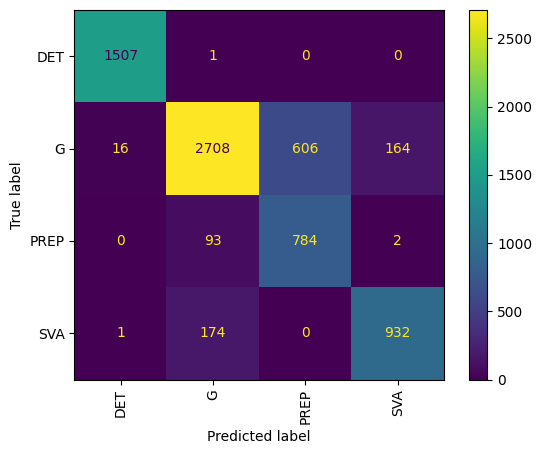

In [ ]:
model_path_e1 = "/content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e1_v20_l4"
model_name_e1 = "v20_l4_e1"
seed_val = 58
model_e1 = fine_tune_model(model_path_e1, train_df, save_path, f"{model_name_e1}_s{seed_val}", seed_val)

# seed 58
model_e1_path = f'/content/drive/MyDrive/VU Thesis/Code/fine_tune/models/seed_fine_tuned_{model_name_e1}_s{seed_val}_model'

preds_e1 = predict_model(model_e1_path, test_data)

target_names = ['DET', 'G', 'PREP','SVA']
report_e1, cf_matrix_e1 = fine_tune_eval(gold_labels, preds_e1, target_names)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e1_v20_l4 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


['DET', 'G', 'PREP', 'SVA']
precision_recall_f1-score
['DET', 'G', 'PREP', 'SVA']
              precision    recall f0.5-score   support

         DET      0.990     1.000     0.992      1508
           G      0.905     0.793     0.880      3494
        PREP      0.553     0.805     0.590       879
         SVA      0.874     0.887     0.877      1107

    accuracy                          0.854      6988
   macro avg      0.830     0.871     0.835      6988
weighted avg      0.874     0.854     0.867      6988

Confusion matrix
['DET', 'G', 'PREP', 'SVA']
[[1508    0    0    0]
 [  13 2769  573  139]
 [   0  169  708    2]
 [   2  123    0  982]]


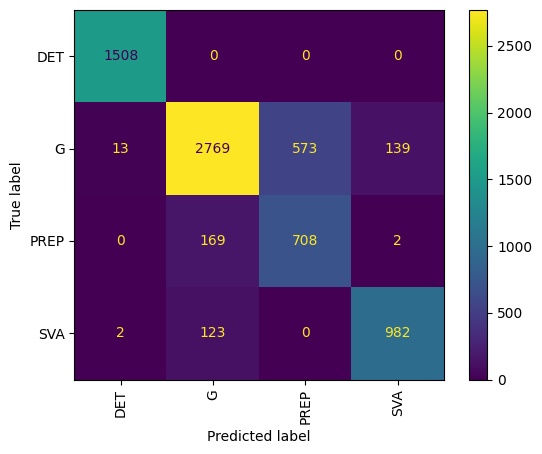

In [ ]:
model_path_e1 = "/content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e1_v20_l4"
model_name_e1 = "v20_l4_e1"
seed_val = 150
model_e1 = fine_tune_model(model_path_e1, train_df, save_path, f"{model_name_e1}_s{seed_val}", seed_val)

# seed 150
model_e1_path = f'/content/drive/MyDrive/VU Thesis/Code/fine_tune/models/seed_fine_tuned_{model_name_e1}_s{seed_val}_model'

preds_e1 = predict_model(model_e1_path, test_data)

target_names = ['DET', 'G', 'PREP','SVA']
report_e1, cf_matrix_e1 = fine_tune_eval(gold_labels, preds_e1, target_names)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e1_v20_l4 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


['DET', 'G', 'PREP', 'SVA']
precision_recall_f1-score
['DET', 'G', 'PREP', 'SVA']
              precision    recall f0.5-score   support

         DET      0.988     1.000     0.990      1508
           G      0.924     0.787     0.893      3494
        PREP      0.569     0.901     0.614       879
         SVA      0.881     0.870     0.879      1107

    accuracy                          0.860      6988
   macro avg      0.840     0.890     0.844      6988
weighted avg      0.886     0.860     0.877      6988

Confusion matrix
['DET', 'G', 'PREP', 'SVA']
[[1508    0    0    0]
 [  15 2750  600  129]
 [   0   86  792    1]
 [   4  140    0  963]]


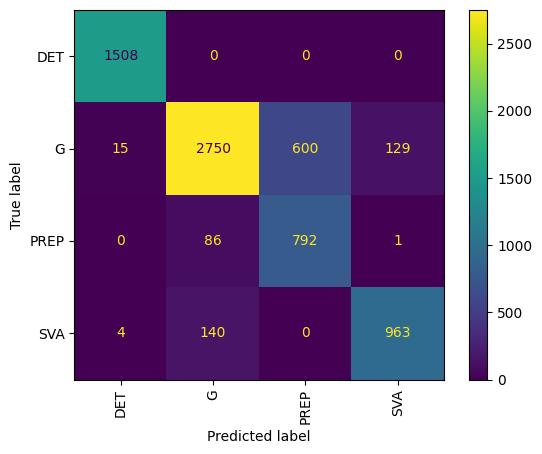

In [ ]:
model_path_e1 = "/content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e1_v20_l4"
model_name_e1 = "v20_l4_e1"
seed_val = 342
model_e1 = fine_tune_model(model_path_e1, train_df, save_path, f"{model_name_e1}_s{seed_val}", seed_val)

# seed 342
model_e1_path = f'/content/drive/MyDrive/VU Thesis/Code/fine_tune/models/seed_fine_tuned_{model_name_e1}_s{seed_val}_model'

preds_e1 = predict_model(model_e1_path, test_data)

target_names = ['DET', 'G', 'PREP','SVA']
report_e1, cf_matrix_e1 = fine_tune_eval(gold_labels, preds_e1, target_names)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e1_v20_l4 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


['DET', 'G', 'PREP', 'SVA']
precision_recall_f1-score
['DET', 'G', 'PREP', 'SVA']
              precision    recall f0.5-score   support

         DET      0.988     1.000     0.990      1508
           G      0.897     0.770     0.869      3494
        PREP      0.558     0.843     0.598       879
         SVA      0.821     0.839     0.824      1107

    accuracy                          0.840      6988
   macro avg      0.816     0.863     0.820      6988
weighted avg      0.862     0.840     0.854      6988

Confusion matrix
['DET', 'G', 'PREP', 'SVA']
[[1508    0    0    0]
 [  13 2692  588  201]
 [   2  134  741    2]
 [   4  174    0  929]]


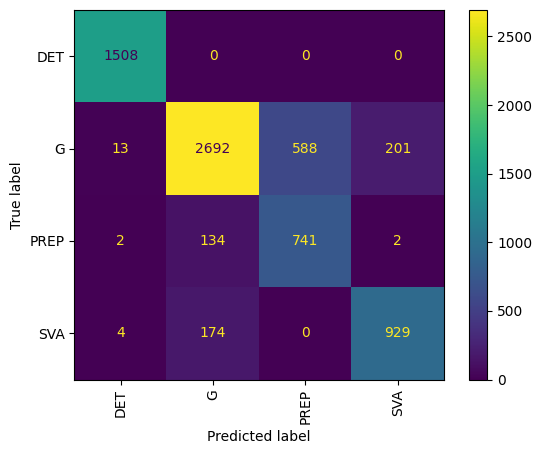

In [ ]:
model_path_e1 = "/content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e1_v20_l4"
model_name_e1 = "v20_l4_e1"
seed_val = 613
model_e1 = fine_tune_model(model_path_e1, train_df, save_path, f"{model_name_e1}_s{seed_val}", seed_val)

# seed 613
model_e1_path = f'/content/drive/MyDrive/VU Thesis/Code/fine_tune/models/seed_fine_tuned_{model_name_e1}_s{seed_val}_model'

preds_e1 = predict_model(model_e1_path, test_data)

target_names = ['DET', 'G', 'PREP','SVA']
report_e1, cf_matrix_e1 = fine_tune_eval(gold_labels, preds_e1, target_names)

#### E5

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e5_v20_l4 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


['DET', 'G', 'PREP', 'SVA']
precision_recall_f1-score
['DET', 'G', 'PREP', 'SVA']
              precision    recall f0.5-score   support

         DET      0.997     0.999     0.997      1508
           G      0.938     0.813     0.910      3494
        PREP      0.558     0.843     0.599       879
         SVA      0.945     0.955     0.947      1107

    accuracy                          0.880      6988
   macro avg      0.859     0.903     0.863      6988
weighted avg      0.904     0.880     0.896      6988

Confusion matrix
['DET', 'G', 'PREP', 'SVA']
[[1507    1    0    0]
 [   5 2842  586   61]
 [   0  137  741    1]
 [   0   50    0 1057]]


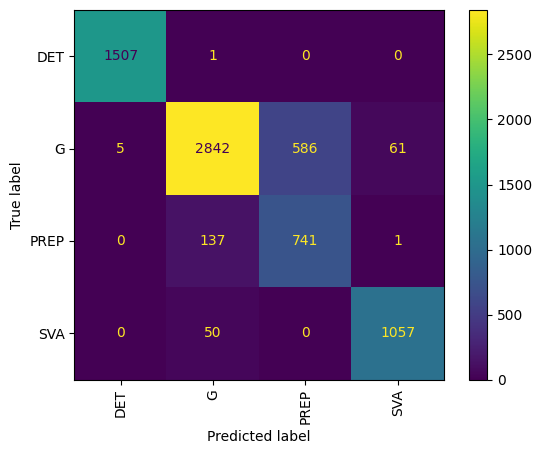

In [ ]:
model_path_e5 = "/content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e5_v20_l4"
model_name_e5 = "v20_l4_e5"
seed_val = 20
model_e5 = fine_tune_model(model_path_e5, train_df, save_path, f"{model_name_e5}_s{seed_val}", seed_val)

# seed 20
model_e5_path = f'/content/drive/MyDrive/VU Thesis/Code/fine_tune/models/seed_fine_tuned_{model_name_e5}_s{seed_val}_model'

preds_e5 = predict_model(model_e5_path, test_data)

target_names = ['DET', 'G', 'PREP','SVA']
report_e5, cf_matrix_e5 = fine_tune_eval(gold_labels, preds_e5, target_names)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e5_v20_l4 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


['DET', 'G', 'PREP', 'SVA']
precision_recall_f1-score
['DET', 'G', 'PREP', 'SVA']
              precision    recall f0.5-score   support

         DET      0.995     1.000     0.996      1508
           G      0.943     0.812     0.913      3494
        PREP      0.563     0.876     0.607       879
         SVA      0.948     0.939     0.946      1107

    accuracy                          0.881      6988
   macro avg      0.862     0.907     0.866      6988
weighted avg      0.907     0.881     0.898      6988

Confusion matrix
['DET', 'G', 'PREP', 'SVA']
[[1508    0    0    0]
 [   7 2836  597   54]
 [   0  106  770    3]
 [   0   67    0 1040]]


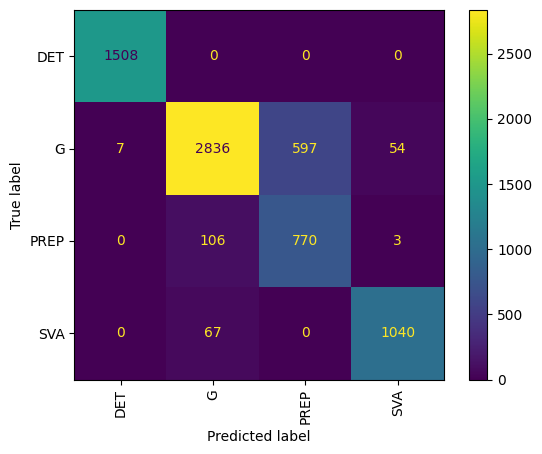

In [ ]:
model_path_e5 = "/content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e5_v20_l4"
model_name_e5 = "v20_l4_e5"
seed_val = 58
model_e5 = fine_tune_model(model_path_e5, train_df, save_path, f"{model_name_e5}_s{seed_val}", seed_val)

# seed 58
model_e5_path = f'/content/drive/MyDrive/VU Thesis/Code/fine_tune/models/seed_fine_tuned_{model_name_e5}_s{seed_val}_model'

preds_e5 = predict_model(model_e5_path, test_data)

target_names = ['DET', 'G', 'PREP','SVA']
report_e5, cf_matrix_e5 = fine_tune_eval(gold_labels, preds_e5, target_names)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e5_v20_l4 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


['DET', 'G', 'PREP', 'SVA']
precision_recall_f1-score
['DET', 'G', 'PREP', 'SVA']
              precision    recall f0.5-score   support

         DET      0.995     1.000     0.996      1508
           G      0.930     0.812     0.904      3494
        PREP      0.554     0.818     0.592       879
         SVA      0.937     0.951     0.940      1107

    accuracy                          0.876      6988
   macro avg      0.854     0.895     0.858      6988
weighted avg      0.898     0.876     0.890      6988

Confusion matrix
['DET', 'G', 'PREP', 'SVA']
[[1508    0    0    0]
 [   7 2838  579   70]
 [   0  159  719    1]
 [   0   54    0 1053]]


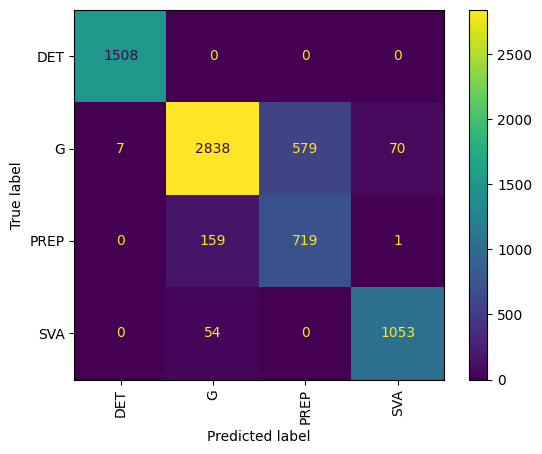

In [ ]:
model_path_e5 = "/content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e5_v20_l4"
model_name_e5 = "v20_l4_e5"
seed_val = 150
model_e5 = fine_tune_model(model_path_e5, train_df, save_path, f"{model_name_e5}_s{seed_val}", seed_val)

# seed 150
model_e5_path = f'/content/drive/MyDrive/VU Thesis/Code/fine_tune/models/seed_fine_tuned_{model_name_e5}_s{seed_val}_model'

preds_e5 = predict_model(model_e5_path, test_data)

target_names = ['DET', 'G', 'PREP','SVA']
report_e5, cf_matrix_e5 = fine_tune_eval(gold_labels, preds_e5, target_names)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e5_v20_l4 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


['DET', 'G', 'PREP', 'SVA']
precision_recall_f1-score
['DET', 'G', 'PREP', 'SVA']
              precision    recall f0.5-score   support

         DET      0.993     1.000     0.994      1508
           G      0.924     0.821     0.902      3494
        PREP      0.556     0.811     0.593       879
         SVA      0.959     0.937     0.955      1107

    accuracy                          0.877      6988
   macro avg      0.858     0.892     0.861      6988
weighted avg      0.898     0.877     0.891      6988

Confusion matrix
['DET', 'G', 'PREP', 'SVA']
[[1508    0    0    0]
 [  11 2870  570   43]
 [   0  165  713    1]
 [   0   70    0 1037]]


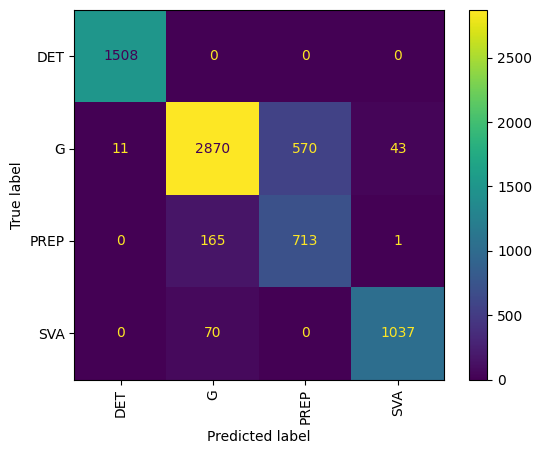

In [ ]:
model_path_e5 = "/content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e5_v20_l4"
model_name_e5 = "v20_l4_e5"
seed_val = 342
model_e5 = fine_tune_model(model_path_e5, train_df, save_path, f"{model_name_e5}_s{seed_val}", seed_val)

# seed 342
model_e5_path = f'/content/drive/MyDrive/VU Thesis/Code/fine_tune/models/seed_fine_tuned_{model_name_e5}_s{seed_val}_model'

preds_e5 = predict_model(model_e5_path, test_data)

target_names = ['DET', 'G', 'PREP','SVA']
report_e5, cf_matrix_e5 = fine_tune_eval(gold_labels, preds_e5, target_names)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e5_v20_l4 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


['DET', 'G', 'PREP', 'SVA']
precision_recall_f1-score
['DET', 'G', 'PREP', 'SVA']
              precision    recall f0.5-score   support

         DET      0.995     1.000     0.996      1508
           G      0.940     0.814     0.912      3494
        PREP      0.559     0.862     0.601       879
         SVA      0.958     0.944     0.955      1107

    accuracy                          0.881      6988
   macro avg      0.863     0.905     0.866      6988
weighted avg      0.907     0.881     0.898      6988

Confusion matrix
['DET', 'G', 'PREP', 'SVA']
[[1508    0    0    0]
 [   8 2844  598   44]
 [   0  119  758    2]
 [   0   62    0 1045]]


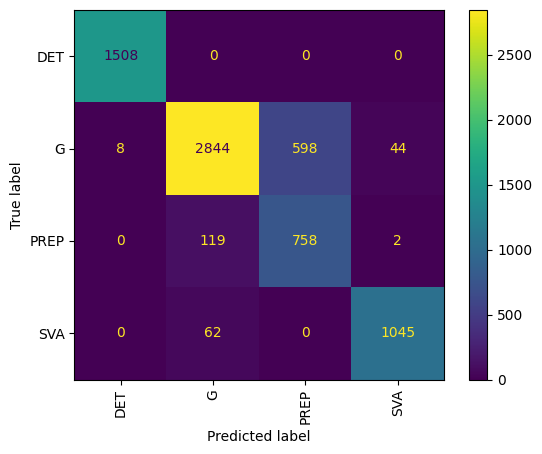

In [ ]:
model_path_e5 = "/content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e5_v20_l4"
model_name_e5 = "v20_l4_e5"
seed_val = 613
model_e5 = fine_tune_model(model_path_e5, train_df, save_path, f"{model_name_e5}_s{seed_val}", seed_val)

# seed 613
model_e5_path = f'/content/drive/MyDrive/VU Thesis/Code/fine_tune/models/seed_fine_tuned_{model_name_e5}_s{seed_val}_model'

preds_e5 = predict_model(model_e5_path, test_data)

target_names = ['DET', 'G', 'PREP','SVA']
report_e5, cf_matrix_e5 = fine_tune_eval(gold_labels, preds_e5, target_names)

#### E10

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e10_v20_l4 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


['DET', 'G', 'PREP', 'SVA']
precision_recall_f1-score
['DET', 'G', 'PREP', 'SVA']
              precision    recall f0.5-score   support

         DET      0.995     0.999     0.996      1508
           G      0.918     0.810     0.894      3494
        PREP      0.551     0.812     0.588       879
         SVA      0.929     0.920     0.927      1107

    accuracy                          0.868      6988
   macro avg      0.848     0.885     0.851      6988
weighted avg      0.890     0.868     0.883      6988

Confusion matrix
['DET', 'G', 'PREP', 'SVA']
[[1507    1    0    0]
 [   5 2829  583   77]
 [   0  164  714    1]
 [   2   87    0 1018]]


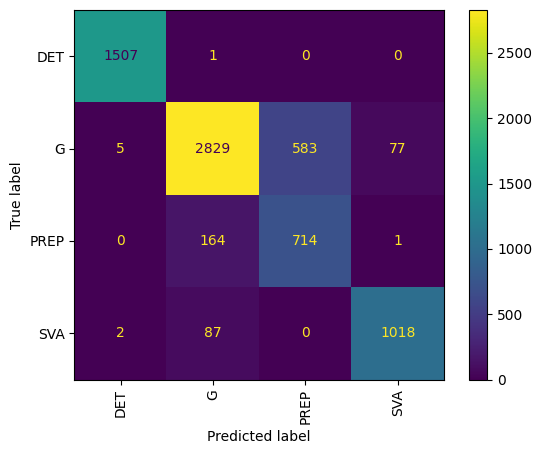

In [ ]:
model_path_e10 = "/content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e10_v20_l4"
model_name_e10 = "v20_l4_e10"
seed_val = 20
model_e10 = fine_tune_model(model_path_e10, train_df, save_path, f"{model_name_e10}_s{seed_val}", seed_val)

# seed 20
model_e10_path = f'/content/drive/MyDrive/VU Thesis/Code/fine_tune/models/seed_fine_tuned_{model_name_e10}_s{seed_val}_model'

preds_e10 = predict_model(model_e10_path, test_data)

target_names = ['DET', 'G', 'PREP','SVA']
report_e10, cf_matrix_e10 = fine_tune_eval(gold_labels, preds_e10, target_names)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e10_v20_l4 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


['DET', 'G', 'PREP', 'SVA']
precision_recall_f1-score
['DET', 'G', 'PREP', 'SVA']
              precision    recall f0.5-score   support

         DET      0.996     1.000     0.997      1508
           G      0.925     0.810     0.899      3494
        PREP      0.553     0.832     0.592       879
         SVA      0.933     0.920     0.930      1107

    accuracy                          0.871      6988
   macro avg      0.852     0.890     0.855      6988
weighted avg      0.895     0.871     0.887      6988

Confusion matrix
['DET', 'G', 'PREP', 'SVA']
[[1508    0    0    0]
 [   5 2829  592   68]
 [   0  143  731    5]
 [   1   88    0 1018]]


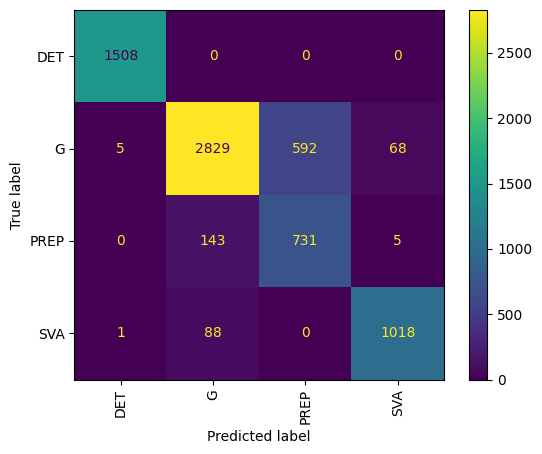

In [ ]:
model_path_e10 = "/content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e10_v20_l4"
model_name_e10 = "v20_l4_e10"
seed_val = 58
model_e10 = fine_tune_model(model_path_e10, train_df, save_path, f"{model_name_e10}_s{seed_val}", seed_val)

# seed 58
model_e10_path = f'/content/drive/MyDrive/VU Thesis/Code/fine_tune/models/seed_fine_tuned_{model_name_e10}_s{seed_val}_model'

preds_e10 = predict_model(model_e10_path, test_data)

target_names = ['DET', 'G', 'PREP','SVA']
report_e10, cf_matrix_e10 = fine_tune_eval(gold_labels, preds_e10, target_names)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e10_v20_l4 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


['DET', 'G', 'PREP', 'SVA']
precision_recall_f1-score
['DET', 'G', 'PREP', 'SVA']
              precision    recall f0.5-score   support

         DET      0.993     1.000     0.995      1508
           G      0.911     0.819     0.891      3494
        PREP      0.548     0.785     0.584       879
         SVA      0.944     0.915     0.938      1107

    accuracy                          0.869      6988
   macro avg      0.849     0.880     0.852      6988
weighted avg      0.888     0.869     0.882      6988

Confusion matrix
['DET', 'G', 'PREP', 'SVA']
[[1508    0    0    0]
 [   7 2860  568   59]
 [   0  188  690    1]
 [   3   91    0 1013]]


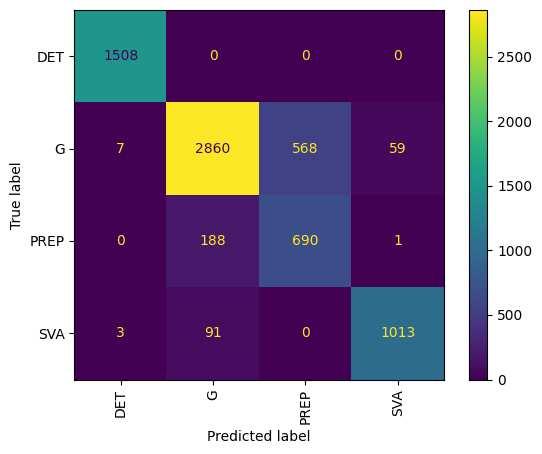

In [ ]:
model_path_e10 = "/content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e10_v20_l4"
model_name_e10 = "v20_l4_e10"
seed_val = 150
model_e10 = fine_tune_model(model_path_e10, train_df, save_path, f"{model_name_e10}_s{seed_val}", seed_val)

# seed 150
model_e10_path = f'/content/drive/MyDrive/VU Thesis/Code/fine_tune/models/seed_fine_tuned_{model_name_e10}_s{seed_val}_model'

preds_e10 = predict_model(model_e10_path, test_data)

target_names = ['DET', 'G', 'PREP','SVA']
report_e10, cf_matrix_e10 = fine_tune_eval(gold_labels, preds_e10, target_names)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e10_v20_l4 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


['DET', 'G', 'PREP', 'SVA']
precision_recall_f1-score
['DET', 'G', 'PREP', 'SVA']
              precision    recall f0.5-score   support

         DET      0.995     0.999     0.996      1508
           G      0.925     0.811     0.900      3494
        PREP      0.556     0.833     0.595       879
         SVA      0.935     0.923     0.933      1107

    accuracy                          0.872      6988
   macro avg      0.853     0.892     0.856      6988
weighted avg      0.895     0.872     0.887      6988

Confusion matrix
['DET', 'G', 'PREP', 'SVA']
[[1507    1    0    0]
 [   7 2833  585   69]
 [   0  145  732    2]
 [   1   84    0 1022]]


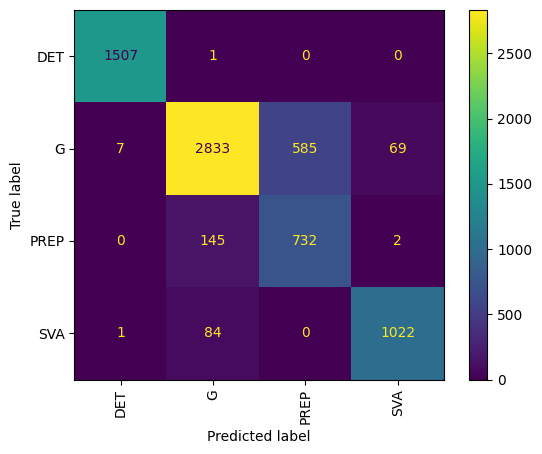

In [ ]:
model_path_e10 = "/content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e10_v20_l4"
model_name_e10 = "v20_l4_e10"
seed_val = 342
model_e10 = fine_tune_model(model_path_e10, train_df, save_path, f"{model_name_e10}_s{seed_val}", seed_val)

# seed 342
model_e10_path = f'/content/drive/MyDrive/VU Thesis/Code/fine_tune/models/seed_fine_tuned_{model_name_e10}_s{seed_val}_model'

preds_e10 = predict_model(model_e10_path, test_data)

target_names = ['DET', 'G', 'PREP','SVA']
report_e10, cf_matrix_e10 = fine_tune_eval(gold_labels, preds_e10, target_names)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e10_v20_l4 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/41 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

Running Epoch 5 of 5:   0%|          | 0/2621 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


['DET', 'G', 'PREP', 'SVA']
precision_recall_f1-score
['DET', 'G', 'PREP', 'SVA']
              precision    recall f0.5-score   support

         DET      0.994     1.000     0.995      1508
           G      0.930     0.809     0.903      3494
        PREP      0.558     0.843     0.599       879
         SVA      0.929     0.927     0.928      1107

    accuracy                          0.873      6988
   macro avg      0.853     0.895     0.856      6988
weighted avg      0.897     0.873     0.888      6988

Confusion matrix
['DET', 'G', 'PREP', 'SVA']
[[1508    0    0    0]
 [   6 2825  586   77]
 [   1  135  741    2]
 [   2   79    0 1026]]


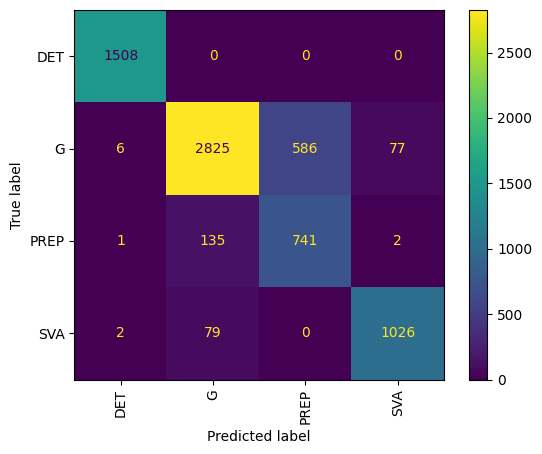

In [ ]:
model_path_e10 = "/content/drive/MyDrive/VU Thesis/Code/baby_models/V20L4/model_e10_v20_l4"
model_name_e10 = "v20_l4_e10"
seed_val = 613
model_e10 = fine_tune_model(model_path_e10, train_df, save_path, f"{model_name_e10}_s{seed_val}", seed_val)

# seed 613
model_e10_path = f'/content/drive/MyDrive/VU Thesis/Code/fine_tune/models/seed_fine_tuned_{model_name_e10}_s{seed_val}_model'

preds_e10 = predict_model(model_e10_path, test_data)

target_names = ['DET', 'G', 'PREP','SVA']
report_e10, cf_matrix_e10 = fine_tune_eval(gold_labels, preds_e10, target_names)